# Statistics Project - Assignment 4

## Previous Assignments

We picked the "Cardiovascular Diseases Risk Prediction Dataset".

https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset?resource=download

In [746]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

np.random.seed(1012)

data = pd.read_csv('CVD_cleaned.csv')

# transformation 1:
data.loc[data["Diabetes"] ==
         'No, pre-diabetes or borderline diabetes', "Diabetes"] = 'at risk'
data = data[data["Diabetes"] != 'Yes, but female told only during pregnancy']

# transformation 2:
data["Numerical_Age_Category"] = data["Age_Category"].apply(
    lambda x: int(x[:2]))

## Part A - Linear Regression

**Research question:** Do changes in exercise (binary), sex (binary), green vegetables consumption (ordinal), and height (continuous), influence weight?

In [747]:
# Get a sample identical to project 3:

small_data = data[['Exercise', 'Sex', 'Green_Vegetables_Consumption', 'Height_(cm)', 'Weight_(kg)']]
sample = small_data.sample(200)
sample.head()

,Exercise,Sex,Green_Vegetables_Consumption,Height_(cm),Weight_(kg)
102725,Yes,Female,60.0,168.0,72.57
195809,No,Female,4.0,155.0,59.87
65238,Yes,Male,12.0,180.0,65.77
167460,Yes,Female,16.0,155.0,62.14
295267,Yes,Female,16.0,157.0,59.87


In [748]:
n = len(sample)

# Transform categorical variables to numeric:
sample_sex_values = sample['Sex'].apply(lambda x: 1 if x == 'Male' else 0)
sample_exercise_values = sample['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create X matrix with a column of ones, and parameters:
x1 = np.concatenate((np.ones((n,1)), np.array(sample_exercise_values).reshape(-1,1)), axis=1)
x2 = np.concatenate((x1, np.array(sample_sex_values).reshape(-1,1)), axis=1)
X = np.concatenate((x2, np.array(sample.iloc[:, 2:4])), axis=1)

# Create y vector:
y = np.array(sample.iloc[:, 4]).reshape(-1,1)

# Calculate the estimated coefficients from equation:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
p = len(beta)

### 1.

In [749]:
# we will assume all the CI's are 95% confidence intervals:
alpha = 0.05

#### 1.a.

In [788]:
# a) Find normal estimated CI:

var_eps = (1/(n - p)) * np.sum((y - X @ beta)**2)
C = np.linalg.inv(X.T @ X)
se_beta = np.sqrt(var_eps * np.diag(C))
print(f"se_beta: {se_beta}")

z_score = stats.norm.ppf(1-(alpha/2))

ci_norm_list = []

for i, b in enumerate(beta):
    ci = (b - z_score * se_beta[i], b + z_score * se_beta[i])
    ci_norm_list.append(ci)
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

se_beta: [25.30442781  2.58807405  3.09964348  0.06708253  0.15701055]
beta 0 CI: (-168.9817, -69.7901)
beta 1 CI: (-9.9622, 0.1829)
beta 2 CI: (-7.8993, 4.2511)
beta 3 CI: (-0.1319, 0.1311)
beta 4 CI: (0.9070, 1.5225)


#### 1.b.

In [751]:
# b) find s.e. bootstrap estimated CI:

## BOOTSTRAP:
B = 400
beta_bootstrap = np.zeros((B, p))

# Run bootstrap:
for i in range(B):
    # sample from X with replacement:
    random_row_indices = np.random.choice(n, n, replace=True)
    sample_row = X[random_row_indices, :]
    # calculate beta_hat:
    beta_hat = np.linalg.inv(sample_row.T @ sample_row) @ sample_row.T @ y
    beta_bootstrap[i, :] = beta_hat.reshape(-1)

# Calculate the standard error of each beta:
se_bootstrap = np.std(beta_bootstrap, axis=0)

In [752]:
ci_boot_se_list = []

# Calculate the CI's:
for i, b in enumerate(beta):
    ci = (b - z_score * se_bootstrap[i], b + z_score * se_bootstrap[i])
    ci_boot_se_list.append(ci)
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

beta 0 CI: (-201.8060, -36.9658)
beta 1 CI: (-13.0778, 3.2984)
beta 2 CI: (-11.9687, 8.3205)
beta 3 CI: (-0.2140, 0.2132)
beta 4 CI: (0.7045, 1.7251)


#### 1.c.

In [753]:
# c) find pivot estimated CI:
ci_pivot_list = []

for i, b in enumerate(beta):
    boot_b = beta_bootstrap[:, i]
    quantile1 = np.quantile(boot_b, 1-(alpha/2), axis=0)
    quantile2 = np.quantile(boot_b, alpha/2, axis=0)
    ci = (2*b - quantile1, 2*b - quantile2)
    ci_pivot_list.append(ci)
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

beta 0 CI: (-394.5223, -232.2188)
beta 1 CI: (-18.5389, -2.1828)
beta 2 CI: (-14.0203, 7.2964)
beta 3 CI: (-0.2188, 0.2217)
beta 4 CI: (1.8588, 2.8896)


#### 1.d.

In [754]:
# d) find percentile estimated CI:
ci_prec_list = []

for i, b in enumerate(beta):
    boot_b = beta_bootstrap[:, i]
    quantile1 = np.quantile(boot_b, 1-(alpha/2), axis=0)
    quantile2 = np.quantile(boot_b, alpha/2, axis=0)
    ci = (quantile2, quantile1)
    ci_prec_list.append(ci)
    print(f"beta {i} CI: ({ci[0]:.4f}, {ci[1]:.4f})")

beta 0 CI: (-6.5530, 155.7505)
beta 1 CI: (-7.5966, 8.7595)
beta 2 CI: (-10.9447, 10.3720)
beta 3 CI: (-0.2225, 0.2180)
beta 4 CI: (-0.4601, 0.5708)


### 2.

In [755]:
# beta on full population:

data_n = len(data)

# Transform categorical variables to numeric:
data_sex_values = data['Sex'].apply(lambda x: 1 if x == 'Male' else 0)
data_exercise_values = data['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create X matrix with a column of ones, and parameters:
x1_data = np.concatenate((np.ones((data_n,1)), np.array(data_exercise_values).reshape(-1,1)), axis=1)
x2_data = np.concatenate((x1_data, np.array(data_sex_values).reshape(-1,1)), axis=1)
X_data = np.concatenate((x2_data, np.array(small_data.iloc[:, 2:4])), axis=1)
# print(X_data)

# Create y vector:
y_data = np.array(small_data.iloc[:, 4]).reshape(-1,1)
# print(y_data)

# Calculate the estimated coefficients from equation:
beta_data = np.linalg.inv(X_data.T @ X_data) @ X_data.T @ y_data

In [756]:
# compare confidence intervals to beta on full population:

len_res_df = pd.DataFrame(columns=['normal_CI', 'bootstrap_se_CI', 'pivot_CI', 'percentile_CI'])
contains_res_df = pd.DataFrame(columns=['normal_CI', 'bootstrap_se_CI', 'pivot_CI', 'percentile_CI'])

def ci_length(ci):
    res = ci[1] - ci[0]
    if type(res) == np.ndarray:
        return res[0]
    return res

def contains_ci(ci, beta):
    return (ci[0] <= beta <= ci[1])[0]

for i in range(len(beta)):
    len_res_df.loc[i] = [ci_length(ci_norm_list[i]), ci_length(ci_boot_se_list[i]), ci_length(ci_pivot_list[i]), ci_length(ci_prec_list[i])]
    contains_res_df.loc[i] = [contains_ci(ci_norm_list[i], beta_data[i]), contains_ci(ci_boot_se_list[i], beta_data[i]), contains_ci(ci_pivot_list[i], beta_data[i]), contains_ci(ci_prec_list[i], beta_data[i])]

print("Length of CI's per beta for each method:")
display(len_res_df)

print("Does CI contain 'true' beta for each method:")
display(contains_res_df)

Length of CI's per beta for each method:


,normal_CI,bootstrap_se_CI,pivot_CI,percentile_CI
0,139.412264,164.840163,162.303461,162.303461
1,14.258740,16.376186,16.356119,16.356119
2,17.077182,20.289211,21.316702,21.316702
3,0.369585,0.427261,0.440552,0.440552
4,0.865034,1.020587,1.030850,1.030850


Does CI contain 'true' beta for each method:


,normal_CI,bootstrap_se_CI,pivot_CI,percentile_CI
0,True,True,False,False
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,False,False


### 3.

In [757]:
# get 100 new points from the population:

n_new = 100

data_without_sample = small_data.drop(sample.index)
new_data = data_without_sample.sample(n_new)

# Transform categorical variables to numeric:
new_data_sex_values = new_data['Sex'].apply(lambda x: 1 if x == 'Male' else 0)
new_data_exercise_values = new_data['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create X matrix with a column of ones, and parameters:
x1_new_data = np.concatenate((np.ones((n_new,1)), np.array(new_data_exercise_values).reshape(-1,1)), axis=1)
x2_new_data = np.concatenate((x1_new_data, np.array(new_data_sex_values).reshape(-1,1)), axis=1)
X_new = np.concatenate((x2_new_data, np.array(new_data.iloc[:, 2:4])), axis=1)

# Create y vector:
y_new = np.array(new_data.iloc[:, 4]).reshape(-1,1)

#### 3.a.

In [758]:
# a) predict y_new using beta from part 1:
y_new_pred = X_new @ beta
print(y_new_pred.shape)

(100, 1)


#### 3.b.

In [759]:
# b) find CI for expected value of y_new:

## BOOTSTRAP:
pred_bootstrap = np.zeros((B, n_new))

# Run bootstrap:
for i in range(B):
    # sample from sample X with replacement:
    random_row_indices = np.random.choice(n, n, replace=True)
    sample_row = X[random_row_indices, :]
    # calculate beta_hat:
    beta_hat = np.linalg.inv(sample_row.T @ sample_row) @ sample_row.T @ y
    
    y_pred = X_new @ beta_hat
    pred_bootstrap[i, :] = y_pred.reshape(-1)

# Calculate the standard error:
se_pred_bootstrap = np.std(pred_bootstrap, axis=0)

# Calculate quantiles:
pred_quantile1 = np.quantile(pred_bootstrap, 1-(alpha/2), axis=0)
pred_quantile2 = np.quantile(pred_bootstrap, alpha/2, axis=0)

In [760]:
# calculate CI's using bootstrap approximation for s.e:
ci_new_lower = []
ci_new_upper = []
ci_new_exp = []

for i in range(X_new.shape[0]):
    x = X_new[i, :]
    y = x @ beta
    ci = ((y - z_score * se_pred_bootstrap[i])[0], (y+ z_score * se_pred_bootstrap[i])[0])
    ci_new_exp.append(ci)
    ci_new_lower.append((y - z_score * se_pred_bootstrap[i])[0])
    ci_new_upper.append((y + z_score * se_pred_bootstrap[i])[0])

In [761]:
# The CI's for the new data points are:
ci_df = pd.DataFrame(columns=['lower', 'upper'])
ci_df['lower'] = ci_new_lower
ci_df['upper'] = ci_new_upper
ci_df.head()

,lower,upper
0,88.080274,97.015340
1,98.384250,113.442240
2,59.972489,72.910924
3,85.044289,103.708822
4,67.176669,82.774646


#### 3.c.

In [762]:
# c) calculate the percentage of new y's that are in the CI:

count = 0

for i in range(n_new):
    if ci_new_lower[i] <= y_new[i] <= ci_new_upper[i]:
        count += 1

print("Percentage of new y's that are in the CI: ", (count/n_new)*100, "%")

Percentage of new y's that are in the CI:  33.0 %


We can see the percentage is far from 95%. This means our assumptions are not met. In addition, we calculated CI for the expectation, not for the value of the new observation. Therefore, the current CI is not expected to work well for the new observation, because we need to take into the consideration the variance of the new observation.

#### 3.d.

To calculate CI for the value of the new observation we need to consider the additional variance of the new observation. 
We can estimate this variance based on the variance of the residuals of the sample (without bootstrapping).

We assume normal distribution of the residuals, and therefore we can use the following formula:
Var(y_new+epsilon) = Var(y_new) + Var(epsilon) = Var(y_new) + sigma^2

We can estimate Var(y_new) by bootstrapping,

Afterwards, we can calculate the CI using the standard formula for CI of normal distribution, with the new variance.

## Part B - Testing

**Research Question:** Does the value of green vegetables' consumption differ between populations which do and don't exercise?


### 1.

Are values of green vegetables' consumption in the exercising population, stochastically bigger than the values of green vegetables' consumption in the non-exercising population?

### 2.

In [763]:
# Get a sample for part B:
n_b = 200

small_data_B = data[['Exercise', 'Green_Vegetables_Consumption']]
sample_b = small_data_B.sample(n_b)

sample_ex = sample_b[sample_b['Exercise'] == "Yes"]
sample_nex = sample_b[sample_b['Exercise'] == "No"]

### 3.

#### 3.a.

In [764]:
# a) 

mu1 = np.mean(sample_ex['Green_Vegetables_Consumption'])
print("mu1: ", mu1)

mu2 = np.mean(sample_nex['Green_Vegetables_Consumption'])
print("mu2: ", mu2)

delta = mu1 - mu2
print("delta: ", delta)

mu1:  15.33774834437086
mu2:  10.571428571428571
delta:  4.766319772942289


Since the variables are not from a known distribution, we cannot assume the means are the MLE's.

#### 3.b.

In [765]:
# b)

## BOOTSTRAP:
delta_bootstrap = np.zeros(B)

# Run bootstrap:
for i in range(B):
    # sample from sample_b with replacement:
    sample_row = sample_b.sample(n_b, replace=True)
    # calculate delta:
    mu1 = sample_row[sample_row['Exercise'] == "Yes"].Green_Vegetables_Consumption.mean()
    mu2 = sample_row[sample_row['Exercise'] == "No"].Green_Vegetables_Consumption.mean()
    delta = mu1 - mu2

    delta_bootstrap[i] = delta

In [766]:
# Calculate the standard error:
se_pred_bootstrap = np.std(delta_bootstrap)
delta_quantile1 = np.quantile(delta_bootstrap, 1-(alpha/2), axis=0)
delta_quantile2 = np.quantile(delta_bootstrap, alpha/2, axis=0)

In [767]:
print("quantile CI for delta: ", (delta_quantile2, delta_quantile1))

quantile CI for delta:  (1.4781128999850934, 8.301049374237506)


#### 3.c.

In [768]:
# c)

full_mu1 = small_data_B[small_data_B['Exercise'] == "Yes"].Green_Vegetables_Consumption.mean()
full_mu2 = small_data_B[small_data_B['Exercise'] == "No"].Green_Vegetables_Consumption.mean()
full_delta = full_mu1 - full_mu2

print("full delta: ", full_delta)
if delta_quantile2 <= full_delta <= delta_quantile1:
    print("full delta is in the CI")
else:
    print("full delta is not in the CI")


full delta:  4.476953203801356
full delta is in the CI


#### 3.d

We will perform the following Wald test:

$$H_0: \delta = \theta_1 - \theta_2 = 0$$
$$H_1: \delta = \theta_1 - \theta_2 > 0$$
$$W = \frac{\hat{\delta} - 0}{\sqrt{s_x^2/n + s_y^2/m}}$$
$$RR = \{W > z_{1-\alpha}\}$$


In [769]:
### Wald test:

n1 = len(sample_b[sample_b['Exercise'] == "Yes"])
n2 = len(sample_b[sample_b['Exercise'] == "No"])

mu1 = sample_b[sample_b['Exercise'] == "Yes"].Green_Vegetables_Consumption.mean()
mu2 = sample_b[sample_b['Exercise'] == "No"].Green_Vegetables_Consumption.mean()

se1 = sample_b[sample_b['Exercise'] == "Yes"].Green_Vegetables_Consumption.std()
se2 = sample_b[sample_b['Exercise'] == "No"].Green_Vegetables_Consumption.std()

W = (mu1 - mu2) / np.sqrt((se1**2)/n1 + (se2**2)/n2)
print("Wald test: ", W)

z_score_one_side = stats.norm.ppf(1-alpha)

if W > z_score_one_side:
    print("Wald test: reject H0")
else:
    print("Wald test: fail to reject H0")

pvalue = 1 - stats.norm.cdf(W)
print("pvalue: ", pvalue)

Wald test:  2.5969278916265828
Wald test: reject H0
pvalue:  0.004703083408034936


We will perform the following permutations test:

$$H_0: F_x = F_y $$
$$H_0: F_x < F_y $$
$$T.S: T_0 = mean(X) - mean(Y)$$
$$pvalue = \frac{1}{B} \sum_{i=1}^{B} I(T_i \geq T_0)$$
$$RR = \{pvalue < \alpha\}$$

In [785]:
### Permutation test:

N = n1 + n2
T0 = mu1 - mu2

## BOOTSTRAP:
permutations_bootstrap = np.zeros(B)

# Run bootstrap:
for i in range(B):
    # sample from sample_b with replacement:
    sample_row = sample_b.sample(n1, replace=False)
    sample_row_complement = sample_b.drop(sample_row.index)
    # calculate statistic:
    mu1_boot = sample_row['Green_Vegetables_Consumption'].mean()
    mu2_boot = sample_row_complement['Green_Vegetables_Consumption'].mean()
    T = mu1_boot - mu2_boot
    permutations_bootstrap[i] = T

pvalue_perm = np.sum(permutations_bootstrap >= T0) / B

if pvalue_perm < alpha:
    print("permutation test: reject H0")
else:
    print("permutation test: fail to reject H0")

print("pvalue_perm: ", pvalue_perm)

permutation test: reject H0
pvalue_perm:  0.0025


### 4.

#### 4.a.

In [771]:
# a)

m1 = np.quantile(sample_ex.Green_Vegetables_Consumption, 0.5, axis=0)
print("m1: ", m1)

m2 = np.quantile(sample_nex.Green_Vegetables_Consumption, 0.5, axis=0)
print("m2: ", m2)

delta_median = m1 - m2
print("delta_median: ", delta_median)

m1:  12.0
m2:  8.0
delta_median:  4.0


Since the variables are not from a known distribution, we cannot assume the means are the MLE's.

#### 4.b.

In [772]:
# b)

## BOOTSTRAP:
delta_med_bootstrap = np.zeros(B)

# Run bootstrap:
for i in range(B):
    # sample from sample_b with replacement:
    sample_row = sample_b.sample(n_b, replace=True)
    # calculate delta:
    m1 = np.quantile(sample_row[sample_row['Exercise'] == "Yes"].Green_Vegetables_Consumption, 0.5)
    m2 = np.quantile(sample_row[sample_row['Exercise'] == "No"].Green_Vegetables_Consumption, 0.5)
    delta = m1 - m2

    delta_med_bootstrap[i] = delta

In [773]:
# Calculate the standard error:
se_pred_bootstrap = np.std(delta_med_bootstrap)
delta_med_quantile1 = np.quantile(delta_med_bootstrap, 1-(alpha/2), axis=0)
delta_med_quantile2 = np.quantile(delta_med_bootstrap, alpha/2, axis=0)

In [774]:
print("quantile CI for delta median: ", (delta_med_quantile2, delta_med_quantile1))

quantile CI for delta median:  (0.0, 8.0)


#### 4.c.

In [775]:
# c)

full_m1 = np.quantile(small_data_B[small_data_B['Exercise'] == "Yes"].Green_Vegetables_Consumption, 0.5, axis=0)
full_m2 = np.quantile(small_data_B[small_data_B['Exercise'] == "No"].Green_Vegetables_Consumption, 0.5, axis=0)
full_delta_med = full_m1 - full_m2

print("full delta: ", full_delta_med)
if delta_med_quantile2 <= full_delta <= delta_med_quantile1:
    print("full delta is in the CI")
else:
    print("full delta is not in the CI")


full delta:  4.0
full delta is in the CI


#### 4.d

We will perform the following permutations test:

$$H_0: F_x = F_y $$
$$H_0: F_x < F_y $$
$$T.S: T_0 = Median_x - Median_y$$
$$pvalue = \frac{1}{B} \sum_{i=1}^{B} I(T_i \geq T_0)$$
$$RR = \{pvalue < \alpha\}$$

In [776]:
### Permutation test:
n1 = len(sample_b[sample_b['Exercise'] == "Yes"])
m1 = np.quantile(sample_b[sample_b['Exercise'] == "Yes"].Green_Vegetables_Consumption, 0.5)
m2 = np.quantile(sample_b[sample_b['Exercise'] == "No"].Green_Vegetables_Consumption, 0.5)
T0 = m1 - m2
print("T0: ", T0)

## BOOTSTRAP:
permutations_bootstrap = np.zeros(B)

# Run bootstrap:
for i in range(B):
    # sample from sample_b with replacement:
    sample_row = sample_b.sample(n1, replace=False)
    sample_row_complement = sample_b.drop(sample_row.index)
    # calculate delta:
    m1 = np.quantile(sample_row.Green_Vegetables_Consumption, 0.5)
    m2 = np.quantile(sample_row_complement.Green_Vegetables_Consumption, 0.5)
    T = m1 - m2
    permutations_bootstrap[i] = T

pvalue_perm = np.sum(permutations_bootstrap >= T0) / B

print("pvalue_perm: ", pvalue_perm)

if pvalue_perm < alpha:
    print("permutation test: reject H0")
else:
    print("permutation test: fail to reject H0")

T0:  4.0
pvalue_perm:  0.305
permutation test: fail to reject H0


* We can use the Wald test for the medians, as we saw in the lecture about wald testing. We will need to adjust it to a one-sided test, and calculate the s.e.(med(x) - med(y)) using a bootstrap technique.

To see if we can use the T-Test, we will check the variances of the groups using an F-test:

In [777]:
population_exercise = sample_b[sample_b['Exercise'] == "Yes"].Green_Vegetables_Consumption
population_wo_exercise = sample_b[sample_b['Exercise'] == "No"].Green_Vegetables_Consumption

n = len(population_exercise)
m = len(population_wo_exercise)

# calculate the estimated variance of the two samples:
S1 = 1/(n-1) * np.sum((population_exercise - np.mean(population_exercise))**2)
S2 = 1/(m-1) * np.sum((population_wo_exercise -
                       np.mean(population_wo_exercise))**2)

# calculate the F Statistic:
if S1 > S2:
    F = S1/S2
else:
    F = S2/S1
print("F = ", F)

# Calculate the f-score for 95% confidence interval:
f_score = stats.f.ppf(q=1-0.05, dfn=n-1, dfd=m-1)
print("f_score = ", f_score)

# Compare the F Statistic to the F critical value:
if F > f_score:
    print("Reject H0")
else:
    print("Accept H0")

F =  1.8014575894039737
f_score =  1.5087878016699776
Reject H0


Therefore, the variances are not identical with a high confidence level.

In conclusion, the assumptions of the T test are not met so we cannot use it.

### 5.

In [782]:
rank_pd = sample_b['Green_Vegetables_Consumption'].rank()
sample_ex_rank = rank_pd[sample_b['Exercise'] == "Yes"]
sample_nex_rank = rank_pd[sample_b['Exercise'] == "No"]

S1_rank = sample_ex_rank.sum()
S2_rank = sample_nex_rank.sum()

print("S1: ", S1)

S1:  16036.5


We will perform the following permutations test:

$$H_0: F_x = F_y $$
$$H_0: F_x < F_y $$
$$T.S: W_s = \sum_{i=1}^{(n)} S_i$$
$$pvalue = \frac{1}{B} \sum_{i=1}^{B} I(W_s \geq W_0)$$
$$RR = \{pvalue < \alpha\}$$


In [783]:
### Permutation test:

## BOOTSTRAP:
permutations_bootstrap = np.zeros(B)

# Run bootstrap:
for i in range(B):
    # sample from sample_b with replacement:
    rank_pd = sample_b['Green_Vegetables_Consumption'].rank()
    sample_rank = rank_pd.sample(n1, replace=False)
    S1_boot = sample_rank.sum()

    permutations_bootstrap[i] = S1_boot

pvalue_perm = np.sum(permutations_bootstrap >= S1_rank) / B

if pvalue_perm < alpha:
    print("permutation test: reject H0")
else:
    print("permutation test: fail to reject H0")

print("pvalue_perm: ", pvalue_perm)


permutation test: reject H0
pvalue_perm:  0.0025


Normal approximation:

$$E_{H_0}(W_s) = \frac{n(N+1)}{2}$$
$$Var_{H_0}(W_s) = \frac{nm(N+1)}{12}$$

$$RR: \frac{W_s - E_{H_0}(W_s)}{\sqrt{Var_{H_0}(W_s)}} > z_{1-\alpha}$$

In [784]:
N = len(sample_b)
n = len(sample_ex)
m = len(sample_nex)

exp_ws = n*(N+1)/2
var_ws = n*m*(N+1)/12

statistic = (S1_rank - exp_ws) / np.sqrt(var_ws)
print("statistic: ", statistic)

z_score_one_side = stats.norm.ppf(1-alpha)

if statistic > z_score_one_side:
    print("Normality assumption test: reject H0")
else:
    print("Normality assumption test: fail to reject H0")

statistic:  2.445734062258505
Normality assumption test: reject H0


With both methods, we reject H0.

### 6.

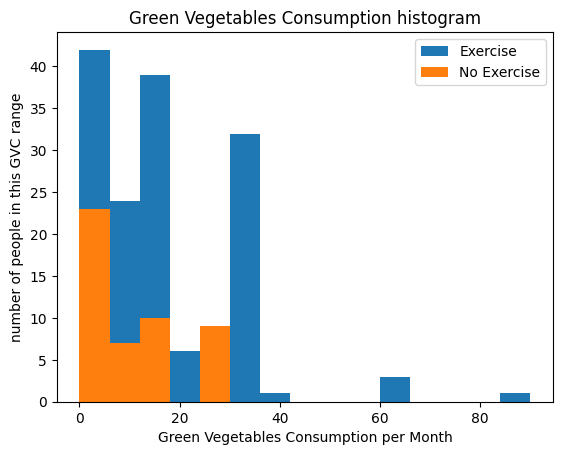

In [780]:
# Plot histogram:
plt.title("Green Vegetables Consumption histogram")
plt.hist(sample_ex.Green_Vegetables_Consumption, bins=15, label='Exercise')
plt.hist(sample_nex.Green_Vegetables_Consumption, bins=5, label='No Exercise')
plt.xlabel("Green Vegetables Consumption per Month")
plt.ylabel("number of people in this GVC range")
plt.legend()
plt.show()

We can see a difference between the distributions in the histogram, so it makes sense that the tests in parts 3-5 generally rejected H0.